In [10]:
import pandas as pd
from sklearn.preprocessing import OrdinalEncoder

df = pd.read_csv("Financial_Records.csv")
df["default"] = df["default"].map({1: 0, 2: 1})  # 0 = good, 1 = bad


# Binary flags for "unknown" or "no checking"
df['savings_unknown'] = df['savings'].str.lower().eq('unknown').astype(int)
df['checking_account_none'] = df['checking_account'].str.lower().str.contains('no checking').astype(int)

# Convert remaining values to numeric (non-convertible values become NaN)
df['savings_numeric'] = pd.to_numeric(df['savings'], errors='coerce')
df['checking_account_numeric'] = pd.to_numeric(df['checking_account'], errors='coerce')

# Fill missing values separately for each class (default = 0 or 1)
df['savings_numeric'] = df.groupby('default')['savings_numeric'].transform(lambda x: x.fillna(x.median()))
df['checking_account_numeric'] = df.groupby('default')['checking_account_numeric'].transform(lambda x: x.fillna(x.median()))

# Drop original columns
df.drop(columns=['savings', 'checking_account'], inplace=True)

# === Continue with bucketing ===

def bucket_employment_since(val):
    val = str(val).strip().lower()
    if val == 'unemployed':
        return 'unemployed'
    if val == '<1 year' or val in ['1', '2', '3', '4']:
        return 'short'
    elif val in ['5', '6', '7']:
        return 'medium'
    else:
        return 'long'

df['employment_since_bucket'] = df['employment_since'].apply(bucket_employment_since)
df.drop(columns=['employment_since'], inplace=True)

def bucket_monthly_rent(val):
    if val == 0:
        return 'none'
    elif val <= 200:
        return 'low'
    elif val <= 400:
        return 'medium'
    else:
        return 'high'

def bucket_credit_amount(val):
    if val <= 1000:
        return 'very_low'
    elif val <= 3000:
        return 'low'
    elif val <= 6000:
        return 'medium'
    else:
        return 'high'

def bucket_duration(val):
    if val <= 12:
        return 'short'
    elif val <= 24:
        return 'medium'
    elif val <= 48:
        return 'long'
    else:
        return 'very_long'

def bucket_age(val):
    if val <= 25:
        return 'young'
    elif val <= 40:
        return 'adult'
    elif val <= 60:
        return 'mature'
    else:
        return 'senior'

df['monthly_rent_bucket'] = df['monthly_rent_or_mortgage'].apply(bucket_monthly_rent)
df['credit_amount_bucket'] = df['credit_amount'].apply(bucket_credit_amount)
df['duration_bucket'] = df['duration'].apply(bucket_duration)
df['age_bucket'] = df['age'].apply(bucket_age)

df.drop(columns=['monthly_rent_or_mortgage', 'credit_amount', 'duration', 'age'], inplace=True)

# Drop PID
df.drop("PID", axis=1, inplace=True)

# === Encode remaining categorical columns ===
categorical_cols = df.select_dtypes(include='object').columns.tolist()

encoder = OrdinalEncoder(dtype=int)
df[categorical_cols] = encoder.fit_transform(df[categorical_cols]) + 1

In [4]:
df_original = df
df_modified = df

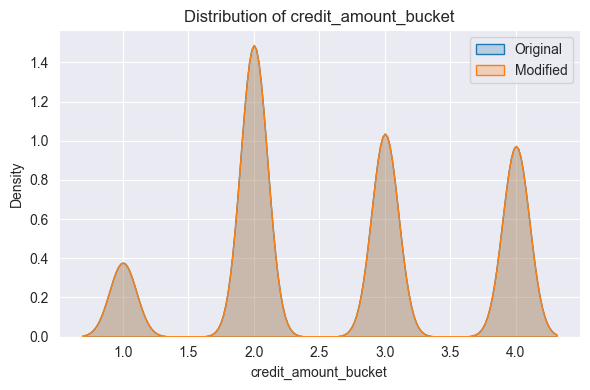

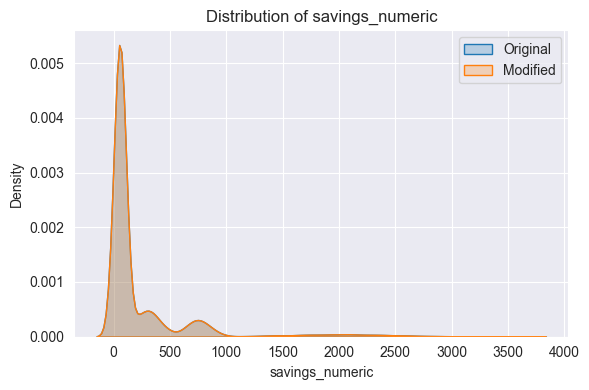

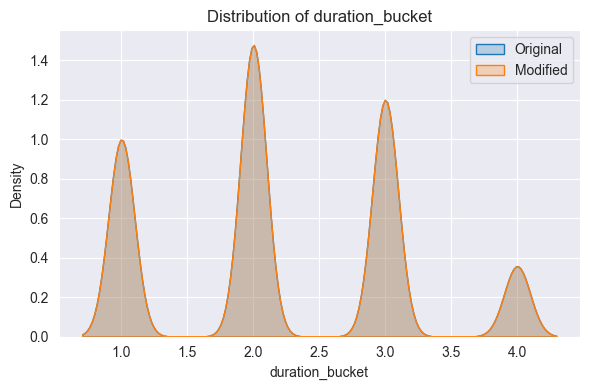

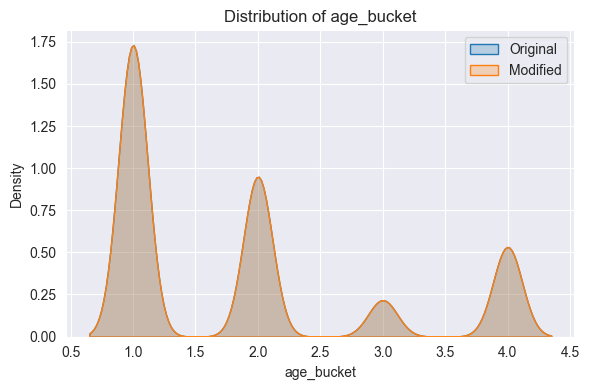

== Mean & Standard Deviation Differences ==
sex: mean diff = 0.0000, std diff = 0.0000
marital_status: mean diff = 0.0000, std diff = 0.0000
job: mean diff = 0.0000, std diff = 0.0000
credit_hist: mean diff = 0.0000, std diff = 0.0000
purpose: mean diff = 0.0000, std diff = 0.0000
installment_rate: mean diff = 0.0000, std diff = 0.0000
debtors: mean diff = 0.0000, std diff = 0.0000
residence_since: mean diff = 0.0000, std diff = 0.0000
property: mean diff = 0.0000, std diff = 0.0000
installment_other: mean diff = 0.0000, std diff = 0.0000
housing: mean diff = 0.0000, std diff = 0.0000
existing_credits: mean diff = 0.0000, std diff = 0.0000
liable_people: mean diff = 0.0000, std diff = 0.0000
tel: mean diff = 0.0000, std diff = 0.0000
online_banking: mean diff = 0.0000, std diff = 0.0000
foreign: mean diff = 0.0000, std diff = 0.0000
savings_unknown: mean diff = 0.0000, std diff = 0.0000
checking_account_none: mean diff = 0.0000, std diff = 0.0000
savings_numeric: mean diff = 0.0000, st

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import entropy
from sklearn.metrics import pairwise_distances

# === Distribution plots ===
columns_to_plot = ['credit_amount_bucket', 'savings_numeric', 'duration_bucket', 'age_bucket']

for col in columns_to_plot:
    plt.figure(figsize=(6, 4))
    if df_original[col].dtype == 'object':
        sns.histplot(df_original[col], label='Original', color='blue', stat='probability', discrete=True, alpha=0.5)
        sns.histplot(df_modified[col], label='Modified', color='orange', stat='probability', discrete=True, alpha=0.5)
    else:
        sns.kdeplot(df_original[col], label='Original', fill=True)
        sns.kdeplot(df_modified[col], label='Modified', fill=True)
    plt.title(f'Distribution of {col}')
    plt.legend()
    plt.tight_layout()
    plt.show()

# === Mean and Std differences ===
print("== Mean & Standard Deviation Differences ==")
numeric_cols = df_original.select_dtypes(include='number').columns.drop("default")

for col in numeric_cols:
    mean_diff = abs(df_original[col].mean() - df_modified[col].mean())
    std_diff = abs(df_original[col].std() - df_modified[col].std())
    print(f"{col}: mean diff = {mean_diff:.4f}, std diff = {std_diff:.4f}")

# === Correlation structure comparison ===
print("\n== Largest Correlation Changes ==")
orig_corr = df_original[numeric_cols].corr()
mod_corr = df_modified[numeric_cols].corr()
corr_diff = (orig_corr - mod_corr).abs()
corr_diff_unstacked = corr_diff.where(np.triu(np.ones(corr_diff.shape), k=1).astype(bool))
print(corr_diff_unstacked.stack().sort_values(ascending=False).head(10))

# === KL divergence for categorical/bucketed features ===
def kl_divergence(col):
    p = df_original[col].value_counts(normalize=True).sort_index()
    q = df_modified[col].value_counts(normalize=True).reindex(p.index).fillna(0)
    return entropy(p, q)

bucketed_features = ['age_bucket', 'checking_account_numeric', 'savings_numeric', 'duration_bucket']

print("\n== KL Divergence (categorical features) ==")
for col in bucketed_features:
    kl = kl_divergence(col)
    print(f"{col}: KL divergence = {kl:.4f}")

# === Pairwise distance shift ===
print("\n== Average Pairwise Distance ==")
sample_cols = numeric_cols[:10]  # use a small subset for speed

orig_sample = df_original[sample_cols].sample(500, random_state=42)
mod_sample = df_modified[sample_cols].sample(500, random_state=42)

orig_dist = pairwise_distances(orig_sample, metric='euclidean')
mod_dist = pairwise_distances(mod_sample, metric='euclidean')

print(f"Original avg pairwise distance: {orig_dist.mean():.4f}")
print(f"Modified avg pairwise distance: {mod_dist.mean():.4f}")


In [6]:
df.head()

,sex,marital_status,job,credit_hist,purpose,installment_rate,debtors,residence_since,property,installment_other,...,default,savings_unknown,checking_account_none,savings_numeric,checking_account_numeric,employment_since_bucket,monthly_rent_bucket,credit_amount_bucket,duration_bucket,age_bucket
0,2,3,4,3,8,4,2,4,4,2,...,0,0,0,17.0,124.0,3,2,1,2,1
1,1,3,4,4,2,3,3,4,2,2,...,1,0,0,21.0,486.0,3,3,3,1,1
2,2,1,1,3,2,4,3,3,2,2,...,0,0,0,229.0,132.0,3,2,4,4,2
3,1,3,1,4,6,4,3,4,4,2,...,0,0,0,45.0,176.0,3,3,2,2,2
4,2,3,2,2,2,4,3,1,1,2,...,1,0,0,74.0,88.0,3,3,3,1,2
